In [1]:
from collections import Counter

from scipy.stats import chisquare
import pandas as pd
import igraph as ig
import numpy as np

from epilink import TOIT, InfectiousnessParams, estimate_linkage_probabilities

from utils import *

set_seaborn_paper_context()

In [2]:
metadata = pd.read_parquet("../data/processed/boston/boston_metadata.parquet")
pair_data = pd.read_parquet("../data/processed/boston/boston_pairwise_distances.parquet")

figs_dir = Path("../figures/main")
sup_figs_dir = Path("../figures/supplementary")
sup_tabs_dir = Path("../tables/supplementary")
tabs_dir = Path("../tables/main")
sup_figs_dir = sup_figs_dir / "boston"

ensure_dirs(figs_dir, sup_figs_dir, tabs_dir, sup_tabs_dir)

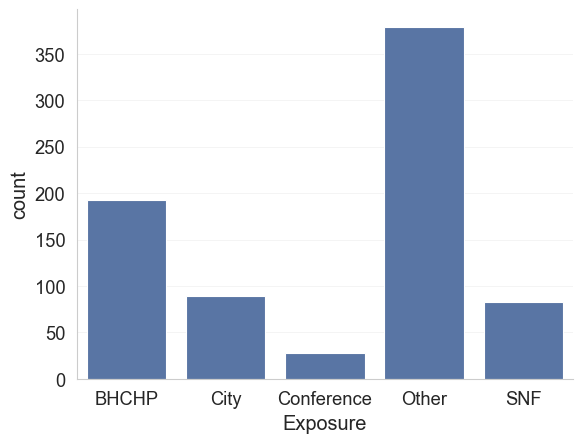

In [43]:
sns.countplot(
    metadata,
    x="Exposure",
);

In [34]:
def hart_default_params() -> InfectiousnessParams:
    return InfectiousnessParams(
        k_inc=5.807,
        scale_inc=0.948,
        k_E=3.38,
        mu=0.37,
        k_I=1,
        alpha=2.29
    )

def build_graph(
        pairwise_df: pd.DataFrame,
        metadata_df: pd.DataFrame,
        minimum_weight: float = 0.0001,
        probability: bool = True
) -> ig.Graph:

    all_ids = pd.unique(pairwise_df[['SeqID1', 'SeqID2']].values.ravel())
    id_to_index = {seq_id: i for i, seq_id in enumerate(all_ids)}
    metadata_dict = metadata_df.set_index('SeqID').to_dict(orient='index')

    g = ig.Graph(n=len(all_ids))

    # Assign vertex names and metadata
    g.vs['SeqID'] = all_ids.tolist()
    g.vs['Date'] = [metadata_dict.get(sid, {}).get('Date') for sid in all_ids]
    g.vs['Clade'] = [metadata_dict.get(sid, {}).get('Clade') for sid in all_ids]
    g.vs['Exposure'] = [metadata_dict.get(sid, {}).get('Exposure') for sid in all_ids]

    if probability:
        filtered = pairwise_df[pairwise_df['Probability'] >= minimum_weight]
    else:
        filtered = pairwise_df[pairwise_df['SNP_Distance'] <= minimum_weight]
    edges = list(zip(filtered['SeqID1'].map(id_to_index), filtered['SeqID2'].map(id_to_index)))
    g.add_edges(edges)

    for col in ['TN93_Distance', 'SNP_Distance', 'Temporal_Distance', 'Probability']:
        g.es[col] = filtered[col].tolist()

    return g

def analyse_partition(
        part:ig.VertexClustering,
        node_attribute="Exposure",
        edge_attributes=None,
        min_size=1
) -> pd.DataFrame:
    if edge_attributes is None:
        edge_attributes = []

    g = part.graph
    results = []

    clusters = [
        (cid, members)
        for cid, members in enumerate(partition)
        if len(members) >= min_size
    ]


    # Get global distribution for the chi-squared test
    all_node_attrs = list(g.vs[node_attribute])
    overall_attr_counts = Counter(all_node_attrs)
    total_nodes = len(all_node_attrs)
    unique_global_attrs = list(overall_attr_counts.keys())

    # Find all unique attribute values across kept clusters
    all_composition_vals = Counter()
    for _, members in clusters:
        vals = g.vs[members][node_attribute]
        all_composition_vals.update(vals)
    all_composition_attrs = [attr for attr, _ in all_composition_vals.most_common()]

    for cid, members in clusters:
        comm_size = len(members)
        subgraph = g.subgraph(members)

        # Node Attribute Composition
        comm_attrs = list(subgraph.vs[node_attribute])
        comm_attr_counts = Counter(comm_attrs)

        # Node Homogeneity Test (Chi-squared)
        observed = np.array([comm_attr_counts.get(attr, 0) for attr in unique_global_attrs], dtype=float)
        p_value = None
        if observed.sum() > 0 and total_nodes > 0:
            expected_props = np.array(
                [overall_attr_counts.get(attr, 0) / total_nodes for attr in unique_global_attrs],
                dtype=float
            )
            expected = expected_props * observed.sum()

            # Filter out expected values of 0 to avoid errors in chisquare
            keep = expected > 0
            if keep.sum() >= 1:
                stat, p_value = chisquare(f_obs=observed[keep], f_exp=expected[keep])

        #Edge Cohesion and Separation
        intra_es = g.es.select(_within=members)
        others = list(set(range(g.vcount())) - set(members))
        inter_es = g.es.select(_between=(members, others))

        edge_stats = {}
        for attr in edge_attributes:
            intra_vals = intra_es[attr]
            inter_vals = inter_es[attr]

            has_intra = len(intra_vals) > 0
            has_inter = len(inter_vals) > 0

            intra_max = np.max(intra_vals) if has_intra else 0

            edge_stats[f"intra_mean_{attr}"] = np.mean(intra_vals) if has_intra else None
            edge_stats[f"intra_max_{attr}"] = intra_max if has_intra else None
            edge_stats[f"intra_min_{attr}"] = np.min(intra_vals) if has_intra else None

            edge_stats[f"inter_min_{attr}"] = np.min(inter_vals) if has_inter else None
            edge_stats[f"inter_mean_{attr}"] = np.mean(inter_vals) if has_inter else None

            dunn_index = (np.mean(inter_vals) / intra_max) if has_inter and has_intra and intra_max > 0 else None
            edge_stats[f"dunn_index_{attr}"] = dunn_index

        # Assemble Row for DataFrame
        row = {
            "cluster_id": cid,
            "size": comm_size,
            f"{node_attribute}_dist": dict(comm_attr_counts),
            "chi2_p_value": p_value,
            **edge_stats,
        }

        total_in_cluster = max(1, sum(comm_attr_counts.values()))
        for attr in all_composition_attrs:
            count = comm_attr_counts.get(attr, 0)
            row[f"count::{attr}"] = count
            row[f"prop::{attr}"] = count / total_in_cluster

        results.append(row)

    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values("size", ascending=False).reset_index(drop=True)
    return df

In [4]:
pair_data["Temporal_Distance"] = np.abs(
    (metadata.set_index("SeqID").loc[pair_data["SeqID1"], "Date"].values -
    metadata.set_index("SeqID").loc[pair_data["SeqID2"], "Date"].values)
    .astype("timedelta64[D]").astype(int))

In [5]:
params = hart_default_params()
toit = TOIT()

pair_data["Probability"] = estimate_linkage_probabilities(
    toit=toit,
    genetic_distance=pair_data["SNP_Distance"].values,
    temporal_distance=pair_data["Temporal_Distance"].values,
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [44]:
resolution = 0.3
probability_threshold = 0.0001
snp_threshold = 2

prob_graph = build_graph(
    pair_data,
    metadata,
    minimum_weight=probability_threshold
)

prob_partition = prob_graph.community_leiden(
    weights="Probability",
    resolution=resolution,
    n_iterations=-1
)

prob_results = analyse_partition(
    prob_partition,
    node_attribute="Exposure",
    edge_attributes=["SNP_Distance", "Temporal_Distance"],
    min_size=2
)


# snp_graph = build_graph(
#     pair_data,
#     metadata,
#     minimum_weight=snp_threshold,
#     probability=False
# )
#
# snp_partition = snp_graph.connected_components()
#
# snp_results = analyse_partition(
#     snp_partition,
#     node_attribute="Exposure",
#     edge_attributes=["SNP_Distance", "Temporal_Distance"],
#     min_size=2
# )

In [49]:
prob_focus = prob_results[(prob_results['count::Conference'] > 0) | (prob_results['count::SNF'] > 0)]

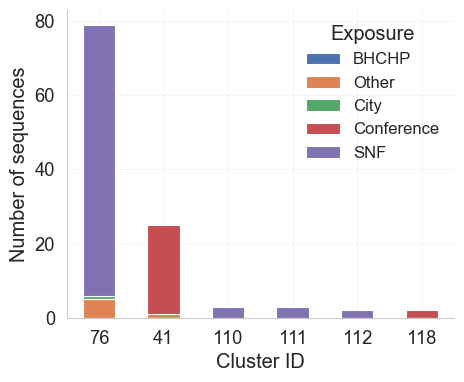

In [68]:
exposures = ['count::BHCHP', 'count::Other', 'count::City', 'count::Conference', 'count::SNF']
exposure_counts = prob_focus[exposures].copy()
exposure_counts.rename(
    columns={
        'count::BHCHP': 'BHCHP',
        'count::Other': 'Other',
        'count::City': 'City',
        'count::Conference': 'Conference',
        'count::SNF': 'SNF'
    },
    inplace=True
)

exposure_counts.index = prob_focus['cluster_id']

exposure_counts.plot(kind='bar', stacked=True, figsize=(5, 4))
# plt.title("Exposure Composition of Clusters with SNF or Conference Cases")
plt.xlabel("Cluster ID")
plt.xticks(rotation=0)
plt.ylabel("Number of sequences")
plt.legend(title="Exposure", fontsize="small", frameon=False)
plt.savefig(figs_dir / "figure2.pdf", bbox_inches="tight")
plt.savefig(figs_dir / "figure2.png", bbox_inches="tight")
plt.show()

In [60]:
prob_summary = prob_focus[[
    'cluster_id',
    'size',
    'intra_mean_SNP_Distance',
    'intra_max_SNP_Distance',
    'intra_mean_Temporal_Distance',
    'intra_max_Temporal_Distance',
    'inter_mean_SNP_Distance',
    'dunn_index_SNP_Distance',
]].copy()

prob_summary.rename(
    columns={
        'cluster_id': 'Cluster ID',
        'size': 'Size',
        'intra_mean_SNP_Distance': 'Intra-SNP (Mean)',
        'intra_max_SNP_Distance': 'Intra-SNP(Max)',
        'intra_mean_Temporal_Distance': 'Intra-Time (Mean)',
        'intra_max_Temporal_Distance': 'Intra-Time (Max)',
        'inter_mean_SNP_Distance': 'Inter-SNP (Mean)',
        'dunn_index_SNP_Distance': 'Dunn Index (Genetic)'
    },
    inplace=True
)

prob_summary.T.to_csv(tabs_dir / "boston_cluster_summary.csv")

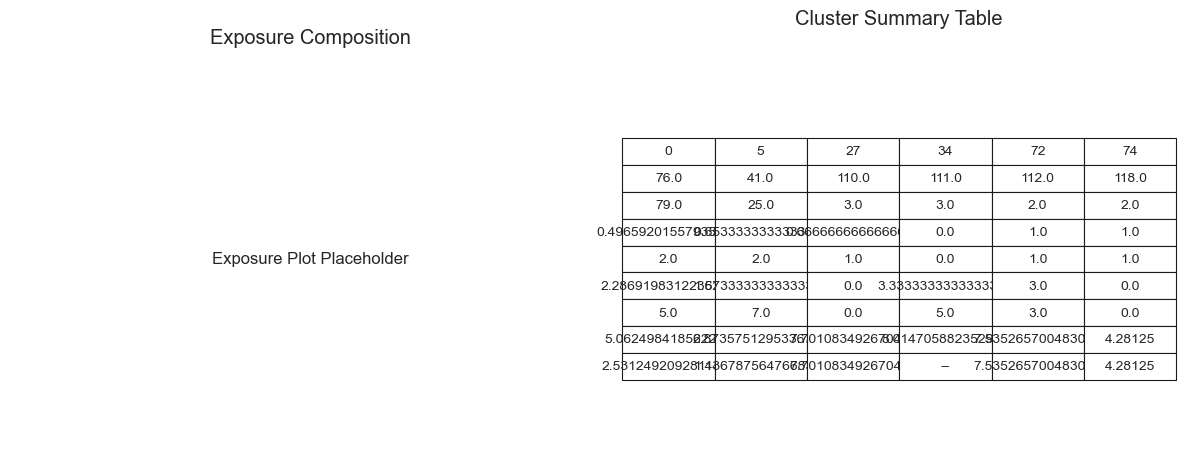

In [66]:
# Sample data (replace with your filtered dataframe)
data = {
    "Cluster ID": [41, 76, 110, 111, 112, 118],
    "Size": [25, 79, 3, 3, 2, 2],
    "Intra SNP": ["0.653\n2", "0.497\n2", "0.667\n1", "0.000\n0", "1.000\n1", "1.000\n1"],
    "Intra Time": ["1.573\n7", "2.287\n5", "0.000\n0", "3.333\n5", "3.000\n3", "0.000\n0"],
    "Inter SNP": [2.874, 5.062, 7.701, 8.015, 7.535, 4.281],
    "Dunn Index": [1.437, 2.531, 7.701, None, 7.535, 4.281]
}
df = prob_summary.T

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.3, 1]})

# --- Left: Placeholder for the exposure composition plot ---
axs[0].text(0.5, 0.5, 'Exposure Plot Placeholder', fontsize=12, ha='center', va='center')
axs[0].set_title("Exposure Composition")
axs[0].axis('off')

# --- Right: Table as a subplot ---
axs[1].axis('off')
table_data = df.fillna("--").astype(str).values.tolist()
columns = df.columns.tolist()
table = axs[1].table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axs[1].set_title("Cluster Summary Table", pad=20)

# --- Final touches ---
plt.tight_layout()
# plt.savefig("combined_cluster_figure.png", dpi=300)
plt.show()